# Embedding nets for observations

!!! note
    You can find the original version of this notebook at [tutorials/04_embedding_networks.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/04_embedding_networks.ipynb) in the `sbi` repository.

## Introduction

When engaging in simulation-based inference, the selection of appropriate summary statistics for observations holds significant importance. These statistics serve to succinctly describe the data generated by simulators, often leveraging domain-specific knowledge. However, in certain scenarios, particularly when dealing with highly complex raw data where domain knowledge may be limited or non-existent, it becomes necessary to learn directly from the data the appropriate summary statistics to employ. `sbi` offers functionality to learn summary statistics from simulation outputs with an **embedding neural network**, referred to as `embedding_net`. 

When an embedding network is used, the posterior approximation for a given observation $x_o$ can be denoted as $q_\phi\big(\theta \mid f_\lambda(x_o)\big)$ where $\phi$ are the parameters of the conditional density estimator and $\lambda$ the parameters of the embedding neural network. Note that the simulation outputs pass through the `embedding_net` before reaching the density estimator and that $\phi$ and $\lambda$ are **jointly learned** during training. `sbi` provides pre-configured embedding networks (MLP, CNN, and permutation-invariant networks) or allows to pass custom-written embedding networks.

It is worth noting that only `NPE` and `NRE` methods can use an `embedding_net` to learn summary statistics from simulation outputs. `NLE` does not offer such functionality because the simulation outputs are also the output of the neural density estimator. 

## Main syntax

```Python
# import required modules
from sbi.neural_nets import posterior_nn

# import the different choices of pre-configured embedding networks
from sbi.neural_nets.embedding_nets import (
    FCEmbedding,
    CNNEmbedding,
    PermutationInvariantEmbedding
)

# choose which type of pre-configured embedding net to use (e.g. CNN)
embedding_net = CNNEmbedding(input_shape=(32, 32))

# instantiate the conditional neural density estimator
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# setup the inference procedure with NPE
inferer = NPE(prior=prior, density_estimator=neural_posterior)

# train the density estimator
density_estimator = inference.append_simulations(theta, x).train()

# build the posterior
posterior = inference.build_posterior(density_estimator)
```

## Inferring parameters from images

In the example that follows, we consider a simple setup where the data points generated by the simulator model are high-dimensional (32x32 grayscale images) and we use a convolutional neural network as summary statistics extractor.

First of all, we import all the packages required for running the tutorial

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sbi import analysis, utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

seed = 0
torch.manual_seed(seed);

/opt/homebrew/Caskroom/miniforge/base/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The simulator model

The simulator model that we consider has two parameters: $r$ and $\theta$. On each run, it generates 100 two-dimensional points centered around $(r \cos(\theta), r \sin(\theta))$ and perturbed by a Gaussian noise with variance 0.01. Instead of simply outputting the $(x,y)$ coordinates of each data point, the model generates a grayscale image of the scattered points with dimensions 32 by 32. This image is further perturbed by an uniform noise with values betweeen 0 and 0.2. The code below defines such model.


In [2]:
def simulator_model(parameter, return_points=False):
    """Simulator model with two-dimensional input parameter and 1024-D output

    This simulator serves as a basic example for using a neural net for learning
    summary features. It has only two input parameters but generates
    high-dimensional output vectors. The data is generated as follows:
        (-) Input:  parameter = [r, phi] (1) Generate 100 two-dimensional
        points centered around (r cos(phi),r sin(phi))
            and perturbed by a Gaussian noise with variance 0.01
        (2) Create a grayscale image I of the scattered points with dimensions
            32 by 32
        (3) Perturb I with an uniform noise with values betweeen 0 and 0.2
        (-) Output: I

    Parameters
    ----------
    parameter : array-like, shape (2)
        The two input parameters of the model, ordered as [r, phi]
    return_points : bool (default: False)
        Whether the simulator should return the coordinates of the simulated
        data points as well

    Returns
    -------
    I: torch tensor, shape (1, 1024)
        Output flattened image
    (optional) points: array-like, shape (100, 2)
        Coordinates of the 2D simulated data points

    """
    r = parameter[0]
    phi = parameter[1]

    sigma_points = 0.10
    npoints = 100
    points = []
    for _ in range(npoints):
        x = r * torch.cos(phi) + sigma_points * torch.randn(1)
        y = r * torch.sin(phi) + sigma_points * torch.randn(1)
        points.append([x, y])
    points = torch.as_tensor(points)

    nx = 32
    ny = 32
    sigma_image = 0.20
    im = torch.zeros(nx, ny)
    for point in points:
        pi = int((point[0] - (-1)) / ((+1) - (-1)) * nx)
        pj = int((point[1] - (-1)) / ((+1) - (-1)) * ny)
        if (pi < nx) and (pj < ny):
            im[pi, pj] = 1
    im = im + sigma_image * torch.rand(nx, ny)
    im = im.T
    im = im.reshape(1, -1)

    if return_points:
        return im, points
    else:
        return im

The figure below shows an example of the output of the simulator when $r = 0.70$ and $\theta = \pi/4$


Text(0.5, 1.0, 'noisy observed data (gray image with 32 x 32 pixels)')

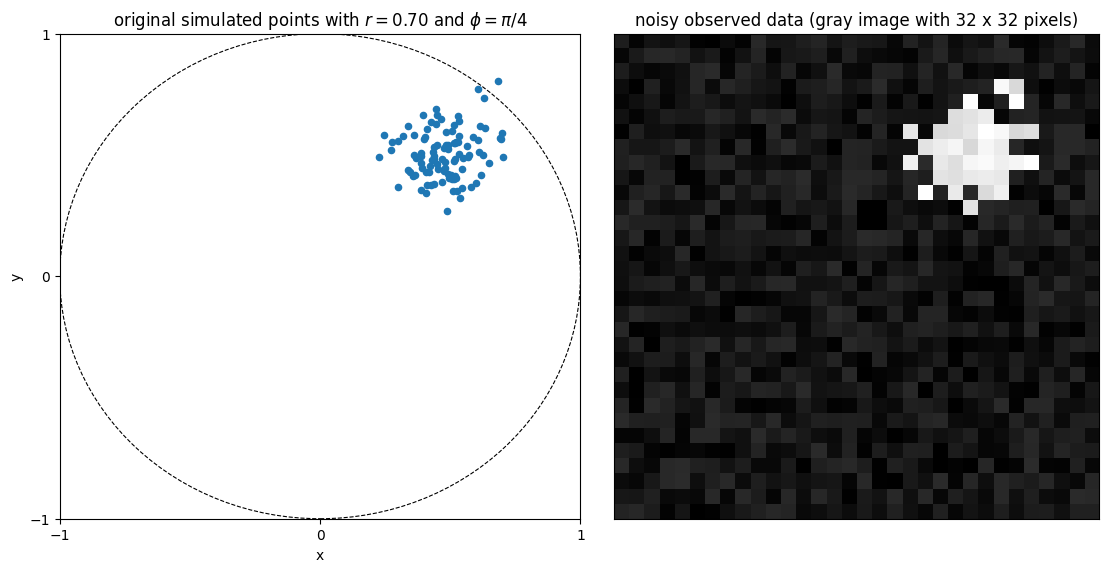

In [3]:
# simulate samples
true_parameter = torch.tensor([0.70, torch.pi / 4])
x_observed, x_points = simulator_model(true_parameter, return_points=True)

# plot the observation
fig, ax = plt.subplots(
    facecolor="white", figsize=(11.15, 5.61), ncols=2, constrained_layout=True
)
circle = plt.Circle((0, 0), 1.0, color="k", ls="--", lw=0.8, fill=False)
ax[0].add_artist(circle)
ax[0].scatter(x_points[:, 0], x_points[:, 1], s=20)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_xlim(-1, +1)
ax[0].set_xticks([-1, 0.0, +1.0])
ax[0].set_ylim(-1, +1)
ax[0].set_yticks([-1, 0.0, +1.0])
ax[0].set_title(r"original simulated points with $r = 0.70$ and $\phi = \pi/4$")
ax[1].imshow(x_observed.view(32, 32), origin="lower", cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("noisy observed data (gray image with 32 x 32 pixels)")

## Choosing an `embedding_net`

The outputs $x$ from the simulator are defined in a 1024 dimensional space (32 x 32 = 1024). To avoid having to setup a conditional neural density estimator to work directly on such high-dimensional vectors, one could use an `embedding_net` that would take the images as input and encode them into smaller vectors.

`sbi` provides pre-configured embedding networks of the following types:

- Fully-connected multi-layer perceptron
- Convolutional neural network (1D and 2D convolutions)
- Permutation-invariant neural network (for trial-based data, see [here](https://sbi-dev.github.io/sbi/latest/tutorials/12_iid_data_and_permutation_invariant_embeddings/))

In the example considered here, the most appropriate `embedding_net` would be a CNN for two-dimensional images. We can setup it as per:


In [4]:
from sbi.neural_nets.embedding_nets import CNNEmbedding

embedding_net = CNNEmbedding(
    input_shape=(32, 32),
    in_channels=1,
    out_channels_per_layer=[6],
    num_conv_layers=1,
    num_linear_layers=1,
    output_dim=8,
    kernel_size=5,
    pool_kernel_size=8
)

!!! note
    See [here](https://github.com/sbi-dev/sbi/blob/main/sbi/neural_nets/embedding_nets.py) for details on all hyperparametes for each available embedding net in `sbi`

## The inference procedure

With the `embedding_net` defined and instantiated, we can follow the usual workflow of an inference procedure in `sbi`. The `embedding_net` object appears as an input argument when instantiating the neural density estimator with `sbi.neural_nets.posterior_nn`.


In [5]:
# set prior distribution for the parameters
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 2 * torch.pi])
)

# make a SBI-wrapper on the simulator object for compatibility
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator_wrapper = process_simulator(simulator_model, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [6]:
from sbi.neural_nets import posterior_nn

# instantiate the neural density estimator
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# setup the inference procedure with NPE
inferer = NPE(prior=prior, density_estimator=neural_posterior)

In [7]:
# run the inference procedure on one round and 10000 simulated data points
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10_000)

100%|██████████| 10000/10000 [00:48<00:00, 208.30it/s]


In [8]:
density_estimator = inferer.append_simulations(theta, x).train(training_batch_size=256)
posterior = inferer.build_posterior(density_estimator)

 Neural network successfully converged after 87 epochs.

## Visualizing the results

We now generate 50000 samples of the posterior distribution of $r$ and $\theta$ when observing an input data point $x$ generated from the `simulator model` with $r = 0.70$ and $\theta = \pi/4$.


In [9]:
# generate posterior samples
true_parameter = torch.tensor([0.50, torch.pi / 4])
x_observed = simulator_model(true_parameter)
samples = posterior.set_default_x(x_observed).sample((50000,))

Drawing 50000 posterior samples: 100%|██████████| 50000/50000 [00:00<00:00, 88523.02it/s]


The figure below shows the statistics of the generated samples.


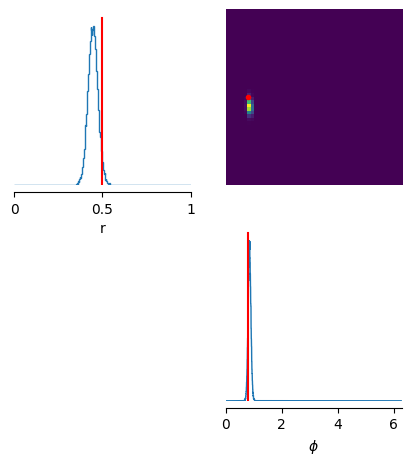

In [12]:
# create the figure
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter,
    labels=["r", r"$\phi$"],
    limits=[[0, 1], [0, 2 * torch.pi]],
    fig_kwargs=dict(
        points_colors="r",
        points_offdiag={"markersize": 6},
    ),
    figsize=(5, 5),
)

## Defining custom embedding networks

It is also possible to define custom embedding networks and pass those to neural density estimator. For example, we could have defined our own architecture for the CNN as per

In [11]:
class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=8, stride=8)
        # Fully connected layer taking as input the 6 flattened output arrays
        # from the maxpooling layer
        self.fc = nn.Linear(in_features=6 * 4 * 4, out_features=8)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6 * 4 * 4)
        x = F.relu(self.fc(x))
        return x

# instantiate the custom embedding_net
embedding_net_custom = SummaryNet()

In [17]:
from torch import Tensor
from sbi.neural_nets.embedding_nets import LRUEmbedding
import math

In [18]:
def test_lru_pipeline():
    """Test an entire pipeline run using the LRU embedding."""

    def _simulator(thetas: Tensor, num_time_steps=500, dt = 0.002, eps=.05) -> Tensor:
        """Create a simple simulator for a one-mass dampened spring system."""
        assert thetas.shape[-1] == 3, "Expected 3 parameters: m, k, d"
        init_state = torch.tensor([[0.2], [0.5]])

        xs = []
        #for theta in thetas:
        # Create the matrices for the ODE, given the parameters.
        m, k, d = thetas
        omega = torch.sqrt(k / m)  # eigen frequency [Hz]
        zeta = d / (2.0 * torch.sqrt(m * k))  # damping ratio [-]
        A = torch.tensor([[0, 1], [-(omega**2), -2.0 * zeta * omega]])

        # Set a fixed initial position and velocity.
        x = init_state.clone()

        # Simulate.
        for t in range(num_time_steps):

            # Compute the ODE's right hand side.
            x_dot = A @ x

            # Integrate one step (forward Euler Maruyama).
            x = x + x_dot * dt + eps * math.sqrt(dt) * torch.randn((2, 1))
            xs.append(x.T.clone())

        return torch.cat(xs, dim=0)
    traj = _simulator(torch.tensor([[1.0, 15.0, 0.7]]))
    assert traj.shape == (500, 2)
    
    # embedding
    embedding_net = LRUEmbedding(
        input_dim=2,
        output_dim=3,
        
    )

    # set prior distribution for the parameters
    prior = utils.BoxUniform(
        low=torch.tensor([0.4, 10.0, 0.5]), high=torch.tensor([2.0, 20.0, 1.0])
    )

    # make a SBI-wrapper on the simulator object for compatibility
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    simulator_wrapper = process_simulator(_simulator, prior, prior_returns_numpy)
    check_sbi_inputs(simulator_wrapper, prior)

    # instantiate the neural density estimator
    neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

    # setup the inference procedure with NPE
    inferer = NPE(prior=prior, density_estimator=neural_posterior)

    # run the inference procedure on one round and 10000 simulated data points
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10)
    density_estimator = inferer.append_simulations(theta, x).train(training_batch_size=5,max_num_epochs=3)
    posterior = inferer.build_posterior(density_estimator)
    
    # generate posterior samples
    true_parameter = torch.tensor([.5, 15.0, 0.7])
    x_observed = _simulator(true_parameter)
    samples = posterior.set_default_x(x_observed).sample((10,))
        
    assert samples.shape == (10, 3)
test_lru_pipeline()

ValueError: not enough values to unpack (expected 3, got 1)